In [1]:
import torch
from utils import *
from torch import nn
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from torch.nn.utils.rnn import pad_sequence


In [2]:
import pathlib
import warnings
warnings.filterwarnings('ignore')

embedding_dir = pathlib.Path('./embeddings')
antipatterns_dict = get_antipattern_dict(embedding_dir)
labels, name2label, label2name = get_labels(antipatterns_dict)
_ = get_embeddings(labels)

In [3]:
class PredictionHead(nn.Module):
    def __init__(self, embedding_dim, conv_out_dim, lstm_hidden, n_labels, filter_size=3, drop_rate_conv=0.3, drop_rate_lstm=0.5):
        super(PredictionHead, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(embedding_dim,
                      conv_out_dim,
                      filter_size,
                      padding=filter_size // 2
                     ),
            nn.ReLU(),
            nn.Dropout(drop_rate_conv)
        )
        self.biLSTM = nn.LSTM(
            input_size=conv_out_dim,
            hidden_size=lstm_hidden,
            bidirectional=True,
            batch_first=True
        )    
        self.out = nn.Linear(2*lstm_hidden, n_labels)
        self.dropout = nn.Dropout(drop_rate_lstm)
    def forward(self, x):
        # Input: Tensor([batch_size, embedding_dim, max_seq])
        
        # Expected: Tensor([batch_size, conv_out_dim, max_seq])
        x = self.conv(x)
        x = self.dropout(x)
        
        # Expected: Tensor([batch_size, max_seq, conv_out_dim])
        x = x.permute(0, 2, 1)

        # Expected: Tensor([batch_size, max_seq, 2*hidden_size])
        outputs, (hn, cn) = self.biLSTM(x)
        cat = torch.cat([hn[0], hn[1]], dim=-1)
        return self.out(self.dropout(cat))

In [4]:
class EmbeddingDataset(Dataset):
    def __init__(self, labels, names):
        self.labels = labels
        self.names = sorted(names, key=lambda x: self.labels[x][-1].shape[1])
        
    def __getitem__(self, idx):
        *labels, _, emb = self.labels[self.names[idx]]
        return torch.FloatTensor(emb), np.array(labels).astype(int)
    
    def __len__(self):
        return len(self.names)

In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(list(labels.keys()), test_size=0.2, random_state=42)

In [6]:
def collate_fn(batch):
    max_sequence_len = max([x[0].shape[1] for x in batch])
    emb_dim = batch[0][0].shape[0]
    sequence_padded = torch.zeros([len(batch), emb_dim, max_sequence_len])
    ys = []
    for i, (X, y) in enumerate(batch):
        sequence_padded[i,:,:X.shape[-1]] = X
        ys.append(y)
    return sequence_padded, torch.Tensor(ys)

In [7]:
from sklearn.metrics import roc_curve
import numpy as np


def get_thresholds_multiclass(predictions, target):
    thresholds = []
    for i in range(predictions.shape[1]):
        fpr, tpr, threshes = roc_curve(target.T[i], predictions.T[i])
        # calculate the g-mean for each threshold
        gmeans = np.sqrt(tpr * (1 - fpr))
        # locate the index of the largest g-mean
        ix = np.argmax(gmeans)
        thresholds.append(threshes[ix])
    return thresholds


# Requires two tensors of size [batch_size, n_classes] and a vector of size [n_classes]
def get_accuracy_multiclass(predictions, target, thresholds=None):
    if thresholds is None:
        thresholds = get_thresholds_multiclass(predictions, target)
    predictions = predictions.T
    target = target.T
    correct = 0
    for i in range(predictions.shape[0]):
        predictions[i] = predictions[i] > thresholds[i]
        correct += np.sum(predictions[i] == target[i])
    return thresholds, correct / (predictions.shape[0] * predictions.shape[1])

In [66]:
def train_step_with_roc(model, train_loader, loss_func, optimizer, device, thresholds):
    model.train()
    losses_train = []
    pbar = tqdm(train_loader)
    preds, lbls = [], []
    for X, y in pbar:
        model.zero_grad()
        lbls.append(y)
        X, y = X.to(device), y.to(device)

        out = model(X)
        preds.append(torch.sigmoid(out).cpu().detach().numpy())

        loss = loss_func(out, y)
        loss.backward()
        optimizer.step()
        # compute metrics
        losses_train.append(loss.item())
        _, acc = get_accuracy_multiclass(np.vstack(preds), np.vstack(lbls), thresholds)
        pbar.set_description(
            f'TRAIN. Mean Loss [{np.mean(losses_train):.2f}]. Accuracy [{acc:.2f}]')
    return losses_train

In [67]:
def train_step(model, train_loader, loss_func, optimizer, device):
    model.train()
    losses_train = []
    correct = 0
    total = 0
    pbar = tqdm(train_loader)
    for X, y in pbar:
        model.zero_grad()
        X, y = X.to(device), y.to(device)
        out = model(X)
        
        loss = loss_func(out, y)
        loss.backward()
        optimizer.step()

        # make predictions
        y = y.reshape(-1).cpu().numpy()
        preds = (torch.sigmoid(out) > 0.5).reshape(-1).detach().cpu().numpy().astype(int)

        # compute metrics
        cur_correct = np.sum(preds == y)
        correct += cur_correct
        total += len(y)
        
        losses_train.append(loss.item())
        pbar.set_description(
            f'TRAIN. Mean Loss [{np.mean(losses_train):.2f}]. Mean Accuracy [{correct / total:.2f}]')
    return losses_train

In [74]:
def valid_step(model, valid_loader, loss_func, device):
    losses_valid = []
    correct = 0
    total = 0
    model.eval()
    pbar = tqdm(valid_loader)
    total_preds = []
    total_lbls = []
    for X, y in pbar:
        X, y = X.to(device), y.to(device)
        out = model(X)

        loss = loss_func(out, y)
        # make predictions
        preds = (torch.sigmoid(out) > 0.5).reshape(-1).detach().cpu().numpy().astype(int)
        total_preds.append((torch.sigmoid(out) > 0.5).detach().cpu().numpy().astype(int))
        total_lbls.append(y.cpu().numpy())
    
        # compute metrics
        y = y.reshape(-1).cpu().numpy()
        cur_correct = np.sum(preds == y)
        correct += cur_correct
        total += len(y)

        losses_valid.append(loss.item())
        pbar.set_description(
            f'VALID. Mean Loss [{np.mean(losses_valid):.2f}]. Mean Accuracy [{correct / total:.2f}]')
    print(classification_report(np.vstack(total_lbls), np.vstack(total_preds)))
    return losses_valid

In [75]:
from sklearn.metrics import classification_report, f1_score
def valid_step_with_roc(model, train_loader, loss_func, device):
    losses_valid = []
    model.eval()
    pbar = tqdm(train_loader)
    preds, lbls = [], []
    for X, y in pbar:
        lbls.append(y)
        X, y = X.to(device), y.to(device)

        out = model(X)
        preds.append(torch.sigmoid(out).cpu().detach().numpy())
        loss = loss_func(out, y)

        # compute metrics
        losses_valid.append(loss.item())
        _, acc = get_accuracy_multiclass(np.vstack(preds), np.vstack(lbls))
        pbar.set_description(
            f'VALID. Mean Loss [{np.mean(losses_valid):.2f}]. Accuracy [{acc:.2f}]')
    preds = np.vstack(preds)
    thresholds, _ = get_accuracy_multiclass(preds, np.vstack(lbls))
    print(classification_report(np.vstack(lbls), preds))
    return losses_valid, thresholds

In [76]:
batch_size = 16
train_dataset = EmbeddingDataset(labels, train)
valid_dataset = EmbeddingDataset(labels, test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, collate_fn=collate_fn)

In [77]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
embedding_dim = 384
conv_out_dim = 128
lstm_hidden = 128
n_labels = len(name2label)

lr = 1e-4
epochs = 5
loss_func = nn.BCEWithLogitsLoss()
thresholds = np.repeat(0.5, n_labels)

In [78]:
model = PredictionHead(embedding_dim, conv_out_dim, lstm_hidden, n_labels)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)


(5480, 4)
(5480, 4)
              precision    recall  f1-score   support

           0       0.26      0.99      0.41      1332
           1       0.93      1.00      0.96      5099
           2       0.16      1.00      0.27       706
           3       0.00      0.00      0.00      1027

   micro avg       0.47      0.87      0.61      8164
   macro avg       0.34      0.75      0.41      8164
weighted avg       0.64      0.87      0.69      8164
 samples avg       0.48      0.88      0.59      8164




(5480, 4)
(5480, 4)
              precision    recall  f1-score   support

           0       0.47      0.91      0.62      1332
           1       0.93      1.00      0.96      5099
           2       0.34      0.95      0.50       706
           3       0.00      0.00      0.00      1027

   micro avg       0.70      0.85      0.77      8164
   macro avg       0.43      0.71      0.52      8164
weighted avg       0.69      0.85      0.75      8164
 samples avg       0.76      0.87      0.78      8164




(5480, 4)
(5480, 4)
              precision    recall  f1-score   support

           0       0.49      0.90      0.64      1332
           1       0.94      1.00      0.97      5099
           2       0.34      0.95      0.50       706
           3       0.86      0.06      0.11      1027

   micro avg       0.71      0.86      0.78      8164
   macro avg       0.66      0.73      0.55      8164
weighted avg       0.80      0.86      0.76      8164
 samples avg       0.78      0.88      0.79      8164




(5480, 4)
(5480, 4)
              precision    recall  f1-score   support

           0       0.46      0.91      0.62      1332
           1       0.95      1.00      0.97      5099
           2       0.33      0.96      0.49       706
           3       0.84      0.12      0.20      1027

   micro avg       0.69      0.87      0.77      8164
   macro avg       0.64      0.75      0.57      8164
weighted avg       0.80      0.87      0.77      8164
 samples avg       0.77      0.89      0.79      8164




(5480, 4)
(5480, 4)
              precision    recall  f1-score   support

           0       0.50      0.89      0.64      1332
           1       0.95      0.99      0.97      5099
           2       0.35      0.95      0.52       706
           3       0.82      0.14      0.24      1027

   micro avg       0.72      0.87      0.79      8164
   macro avg       0.66      0.75      0.59      8164
weighted avg       0.81      0.87      0.79      8164
 samples avg       0.79      0.89      0.81      8164



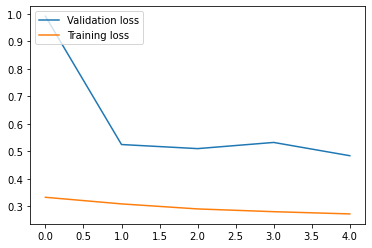

In [79]:
from tqdm.notebook import tqdm
valid_means = []
train_means = []
for epoch in range(epochs):
    losses_train = train_step(model, train_loader, loss_func, optimizer, device)
    losses_valid = valid_step(model, valid_loader, loss_func, device)
    valid_means.append(np.mean(losses_valid))
    train_means.append(np.mean(losses_train))

plt.plot(valid_means)
plt.plot(train_means)
plt.legend(["Validation loss", "Training loss"], loc="upper left")
plt.show()

In [80]:
model = PredictionHead(embedding_dim, conv_out_dim, lstm_hidden, n_labels)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)


              precision    recall  f1-score   support

           0       0.49      0.85      0.62      1332
           1       0.97      0.75      0.84      5099
           2       0.38      0.85      0.52       706
           3       0.24      0.56      0.33      1027

   micro avg       0.60      0.75      0.66      8164
   macro avg       0.52      0.75      0.58      8164
weighted avg       0.75      0.75      0.71      8164
 samples avg       0.62      0.74      0.64      8164




              precision    recall  f1-score   support

           0       0.56      0.85      0.68      1332
           1       0.97      0.82      0.89      5099
           2       0.47      0.89      0.62       706
           3       0.25      0.51      0.34      1027

   micro avg       0.66      0.79      0.72      8164
   macro avg       0.56      0.77      0.63      8164
weighted avg       0.77      0.79      0.76      8164
 samples avg       0.67      0.78      0.69      8164




              precision    recall  f1-score   support

           0       0.59      0.82      0.69      1332
           1       0.97      0.84      0.90      5099
           2       0.48      0.89      0.62       706
           3       0.26      0.54      0.35      1027

   micro avg       0.68      0.80      0.74      8164
   macro avg       0.58      0.77      0.64      8164
weighted avg       0.78      0.80      0.77      8164
 samples avg       0.69      0.80      0.71      8164




              precision    recall  f1-score   support

           0       0.57      0.84      0.68      1332
           1       0.97      0.84      0.90      5099
           2       0.53      0.86      0.65       706
           3       0.25      0.58      0.35      1027

   micro avg       0.67      0.81      0.73      8164
   macro avg       0.58      0.78      0.65      8164
weighted avg       0.78      0.81      0.78      8164
 samples avg       0.69      0.81      0.71      8164




              precision    recall  f1-score   support

           0       0.57      0.85      0.68      1332
           1       0.97      0.86      0.91      5099
           2       0.52      0.86      0.65       706
           3       0.26      0.57      0.36      1027

   micro avg       0.68      0.82      0.74      8164
   macro avg       0.58      0.79      0.65      8164
weighted avg       0.78      0.82      0.78      8164
 samples avg       0.70      0.83      0.73      8164



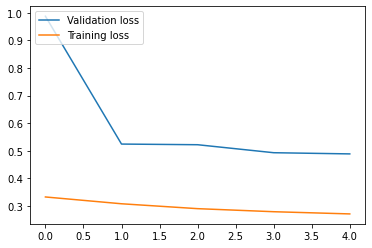

In [81]:
from tqdm.notebook import tqdm
valid_means = []
train_means = []
for epoch in range(epochs):
    losses_train = train_step_with_roc(model, train_loader, loss_func, optimizer, device, thresholds)
    losses_valid, thresholds  = valid_step_with_roc(model, valid_loader, loss_func, device)
    valid_means.append(np.mean(losses_valid))
    train_means.append(np.mean(losses_train))

plt.plot(valid_means)
plt.plot(train_means)
plt.legend(["Validation loss", "Training loss"], loc="upper left")
plt.show()